In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]
from tensorflow.keras import layers, Model, Input
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def split_data(data_dir):
    batch_size = 32
    img_height = 224
    img_width = 224

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    class_names = np.array(train_ds.class_names)

    normalization_layer = layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    return class_names,train_ds,val_ds


class_names,x_train,  x_valid   =split_data('../Data/data_augmentation/' )

Found 8690 files belonging to 49 classes.
Using 6952 files for training.
Found 8690 files belonging to 49 classes.
Using 1738 files for validation.


In [3]:
y_train = np.concatenate([y for x, y in x_train], axis=0)
y_valid = np.concatenate([y for x, y in x_valid], axis=0)
y_train.shape,y_valid.shape

((6952,), (1738,))

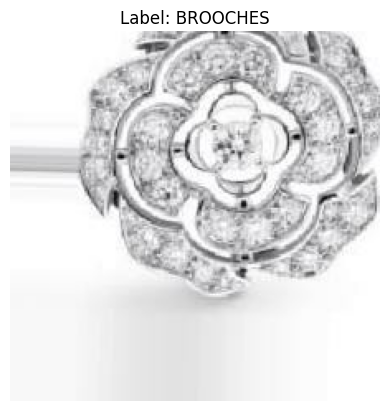

In [ ]:
for images, labels in x_train.take(1):  
    image = images[5]  
    label = labels[5]  

plt.imshow(tf.convert_to_tensor(image).numpy()) 
plt.title(f"Label: {class_names[label.numpy()]}")
plt.axis("off")
plt.show()

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  
image_size = 224  
patch_size = 32  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
] 

In [5]:
for image_batch, labels_batch in x_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


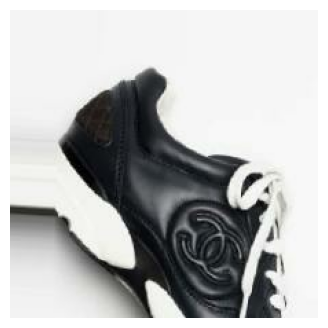

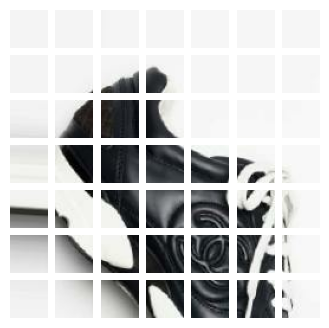

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    


plt.figure(figsize=(4, 4))
image = image_batch[6]
plt.imshow(tf.convert_to_tensor(image).numpy()) 
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(tf.convert_to_tensor(patch_img).numpy())
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config
    

In [10]:
def vit_model():
    inputs = tf.keras.Input(shape=(224,224,3))  
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    #representation = layers.Dropout(0.2)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(len(class_names))(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model

model = vit_model()


In [11]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "../weights/best_Vit.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)
history = model.fit(
    x=x_train,
    validation_data=x_valid, 
    epochs=num_epochs,
    callbacks=[early_stopping,lr_reduction,checkpoint_callback],
)

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.0687 - loss: 4.2956 - top-5-accuracy: 0.2626 - val_accuracy: 0.3987 - val_loss: 1.8586 - val_top-5-accuracy: 0.8613 - learning_rate: 0.0010
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.2877 - loss: 2.2735 - top-5-accuracy: 0.7451 - val_accuracy: 0.5552 - val_loss: 1.2533 - val_top-5-accuracy: 0.9396 - learning_rate: 0.0010
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.4138 - loss: 1.7657 - top-5-accuracy: 0.8689 - val_accuracy: 0.6588 - val_loss: 1.0275 - val_top-5-accuracy: 0.9787 - learning_rate: 0.0010
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.4886 - loss: 1.4900 - top-5-accuracy: 0.9198 - val_accuracy: 0.6640 - val_loss: 0.8834 - val_top-5-accuracy: 0.9804 - learning_rate: 0.0010
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.5638 - loss: 1.2561 - top-5-accuracy: 0.9491 - val_accuracy: 0.7629 - val_loss: 0.6800 - val_top-5-accura

In [12]:
# model.load_weights(checkpoint_filepath)
loss, accuracy, top_5_accuracy = model.evaluate(x_valid)  
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8381 - loss: 0.4025 - top-5-accuracy: 0.9988
Test accuracy: 83.37%
Test top 5 accuracy: 99.83%


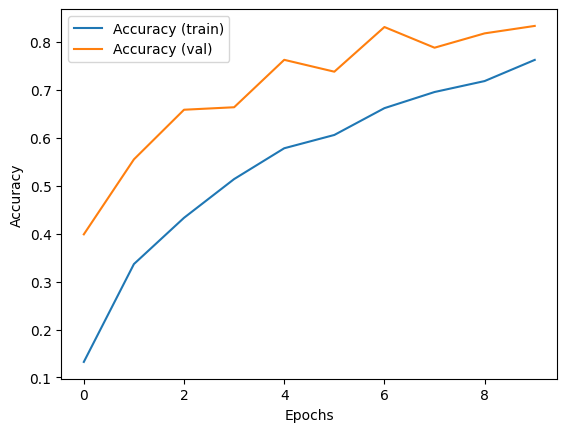

In [13]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, 49, 3072)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 49, 64)    │    199,808 │ patches_2[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 49, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 49, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 49, 64)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 49, 64)    │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 49, 128)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 28,315,541 (108.02 MB)

 Trainable params: 9,438,513 (36.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,877,028 (72.01 MB)

In [44]:
import tensorflow as tf
from keras import Model

#encoder_test = Model(inputs=model.layers[79].input, outputs=model.layers[79].output)
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

In [39]:
for image_batch, label_batch in x_train:
    print("Shape of image batch:", image_batch.shape)  
    print("Shape of label batch:", label_batch.shape)  
    print("Range of pixel values in image batch:", (tf.reduce_min(image_batch), tf.reduce_max(image_batch)))
    break 


Shape of image batch: (32, 224, 224, 3)
Shape of label batch: (32,)
Range of pixel values in image batch: (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)


In [45]:

embeddings = embedding_model.predict(x_train)
print("embeddings:", embeddings.shape)


218/218 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step
embeddings: (6952, 1024)


In [49]:
embeddings

array([[ 1.1963683e+00, -1.5992996e-01, -3.2546986e-02, ...,
         8.9372426e-01, -1.4276984e-01, -1.5242232e-01],
       [ 9.6867621e-01, -1.4188312e-01, -9.7375721e-02, ...,
         1.1595905e+00, -1.5758057e-01, -1.5590481e-01],
       [-4.0464006e-02,  7.4420519e+00, -4.5918257e-15, ...,
         4.0543127e-01, -7.8148531e-08, -1.9024021e-03],
       ...,
       [-1.1395081e-01, -1.6843016e-01, -8.3758622e-02, ...,
        -1.6239090e-01, -1.1795679e-01, -1.1498416e-01],
       [-1.5134560e-01, -1.2206856e-01, -8.9555815e-02, ...,
        -1.5515135e-01,  1.2815645e-01, -3.1680785e-02],
       [-3.6488604e-02,  1.6667774e+00, -6.0379859e-03, ...,
        -2.9374734e-02, -1.6857195e-01, -1.2133550e-01]], dtype=float32)

In [51]:
labels = np.concatenate([y for x, y in x_train], axis=0)

In [54]:
np.save('../embaddings/VIT_embeddings_intermediaire.npy', embeddings)
np.save('../embaddings/VIT_labels.npy', labels)

In [60]:
embaddings_model = model.predict(x_train)
np.save('../embaddings/VIT_embeddings.npy', embaddings_model)

218/218 ━━━━━━━━━━━━━━━━━━━━ 147s 670ms/step


***Test it sur des images hors de la dataset***

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Prédictions : ['HANDBAGS']


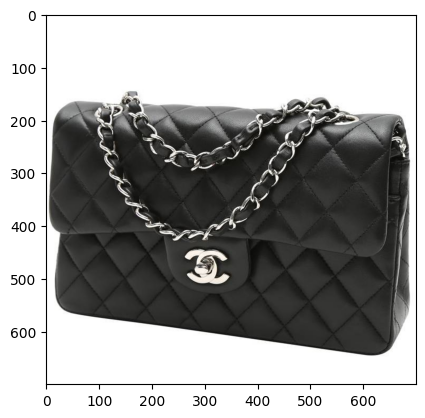

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

img_path = '../Data/test_data/1.jpg'
img_array = load_and_preprocess_image(img_path)
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = class_names[predicted_class]
print("Prédictions :", predicted_label)
img = Image.open(img_path)
plt.imshow(img)
